In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
nielsen15 = pd.read_csv('../../Nielsen/aggregated_nielsen_2015.csv')
nielsen16 = pd.read_csv('../..//Nielsen/aggregated_nielsen_2016.csv')
nielsen15['year'] = 2015
nielsen16['year'] = 2016

In [3]:
nielsen = pd.concat((nielsen15, nielsen16))
nielsen = nielsen[~nielsen.is_walmart]

In [4]:
## Entriy/exit dates
fandom = pd.read_csv('../data_collection/plein_de_data/fandom_traitées.csv', parse_dates=['Opening_date', 'Closing_date'])[['State', 'County_name', 'County_fips', 'Opening_date', 'Closing_date']]

# We drop the state in which we do not trust our data (some mistakes stil remain)
fandom = fandom[~np.isin(fandom.State, ('CA', 'GA', 'KS', 'LA', 'TX'))]

# We concentrate our study on the movements (entries & exits) during the fiscal years 2015 and 2016
movements = fandom[((fandom.Opening_date >= '2015-01-31') & (fandom.Opening_date <= '2017-01-31')) | ((fandom.Closing_date >= '2015-01-31') & (fandom.Closing_date <= '2017-01-31'))]
#movements['year'] = movements.Opening_date.dt.year
#movements['month'] = movements.Opening_date.dt.month

## FIRST MODEL : one month

Regression model :
$$ Price_{i, t} = \alpha + \beta \cdot treat_i + \gamma \cdot post_t + \delta \cdot treat_i \cdot post_{t} + \varepsilon_{i, t}$$

In [5]:
year = 2016
month = 1

In [6]:
# We choose to focus on milk prices
milk = nielsen[nielsen.product_group_descr == 'MILK']


# The control group is composed by all states where nothing (no entry nor exit) happened.
control = milk[~np.isin(milk.guessed_store_county_fips, movements)].copy()
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")


# The treatment group is composed by the states where one entry took place in august 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.Opening_date + count.Closing_date == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index)) & (movements.Opening_date.dt.year == year) & (movements.Opening_date.dt.month == month)]

treatment = milk[np.isin(milk.guessed_store_county_fips, treatment_movements.County_fips )].copy()
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")


# We create our dummies for the regression
control['treat'] = False
control['post'] = (control.purchase_month > month) & (control.purchase_year == year)
treatment['treat'] = True
treatment['post'] = (treatment.purchase_month > month) & (treatment.purchase_year == year)


# Final dataset for the regression :

df = pd.concat((control, treatment))[['upc_price', 'treat', 'post']]
df = df[df.upc_price != 0]

Size of the control group: 2279.
Size of the treatment group: 15.


In [7]:
reg = smf.ols(formula='np.log(upc_price) ~ treat * post', data=df)
results = reg.fit()

In [8]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(upc_price)   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     220.3
Date:                Thu, 27 Oct 2022   Prob (F-statistic):          7.49e-142
Time:                        10:13:47   Log-Likelihood:                 1814.8
No. Observations:               44561   AIC:                            -3622.
Df Residuals:                   44557   BIC:                            -3587.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      1.0080      0.001    673.336      0.000       1.005       1.011
treat[T.True]                 -0.0396      0.017     -2.366      0.018      -0.072      -0.007
post[T.True]                  -0.0561      0.002    -25.288      0.000      -0.060      -0.052
treat[T.True]:post[T.True]    -0.0121      0.025     -0.489      0.625      -0.060       0.036
==============================================================================
Omnibus:                     4270.644   Durbin-Watson:                   0.957
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            22451.454
Skew:                          -0.319   Prob(JB):                         0.00
Kurtosis:                       6.418   Cond. No.                         28.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## SECOND MODEL : all months

Regression model :
$$ Price_{i, t} = \alpha + \beta \cdot treat_i + \delta \cdot treat_i \cdot post_{t} + \varepsilon_{i, t}$$

In [9]:
# We choose to focus on milk prices
milk = nielsen[nielsen.product_group_descr == 'MILK']


# The control group is composed by all states where nothing (no entry nor exit) happened.
control = milk[~np.isin(milk.guessed_store_county_fips, movements)].copy()
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")


# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.Opening_date + count.Closing_date == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]

treatment = milk[np.isin(milk.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")


# We create our dummies for the regression
control['treat'] = False
control['interaction'] = False
treatment['treat'] = True
treatment['interaction'] = (treatment.purchase_month > treatment.Opening_date.dt.month) & (treatment.purchase_year >= treatment.Opening_date.dt.year)


# Final dataset for the regression :

df = pd.concat((control, treatment))[['upc_price', 'treat', 'interaction']]
df = df[df.upc_price != 0]

Size of the control group: 2279.
Size of the treatment group: 89.


In [10]:
reg = smf.ols(formula='np.log(upc_price) ~ treat + interaction', data=df)
results = reg.fit()

In [11]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(upc_price)   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     12.01
Date:                Thu, 27 Oct 2022   Prob (F-statistic):           6.08e-06
Time:                        10:13:51   Log-Likelihood:                 1977.3
No. Observations:               46318   AIC:                            -3949.
Df Residuals:                   46315   BIC:                            -3922.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               0.9824      0.001    890.825      0.000       0.980       0.985
treat[T.True]           0.0240      0.006      3.810      0.000       0.012       0.036
interaction[T.True]    -0.0502      0.011     -4.709      0.000      -0.071      -0.029
==============================================================================
Omnibus:                     4417.753   Durbin-Watson:                   0.925
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21484.694
Skew:                          -0.348   Prob(JB):                         0.00
Kurtosis:                       6.263   Cond. No.                         10.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
np.exp(results.params[2])-1

-0.0489590882635037

## THIRD MODEL : adding time fixed effects

Regression model :
$$ Price_{i, t} = \alpha + \beta \cdot treat_i + \delta \cdot treat_i \cdot post_{t} + \sum_{\tau=Janv15}^{Dec16}\gamma_{\tau} \cdot \mathbb{1}(t=\tau) + \varepsilon_{i, t}$$

In [13]:
# We choose to focus on milk prices
milk = nielsen[nielsen.product_group_descr == 'MILK']


# The control group is composed by all states where nothing (no entry nor exit) happened.
control = milk[~np.isin(milk.guessed_store_county_fips, movements)].copy()
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")


# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.Opening_date + count.Closing_date == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]

treatment = milk[np.isin(milk.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")


# We create our dummies for the regression
control['treat'] = False
control['interaction'] = False
control['time_fixed_effects'] = list(zip(control.purchase_year, control.purchase_month))
treatment['treat'] = True
treatment['interaction'] = (treatment.purchase_month > treatment.Opening_date.dt.month) & (treatment.purchase_year >= treatment.Opening_date.dt.year)
treatment['time_fixed_effects'] = list(zip(treatment.purchase_year, treatment.purchase_month))


# Final dataset for the regression :

df = pd.concat((control, treatment))[['upc_price', 'treat', 'interaction', 'time_fixed_effects']]
df = df[df.upc_price != 0]

Size of the control group: 2279.
Size of the treatment group: 89.


In [14]:
reg = smf.ols(formula='np.log(upc_price) ~ treat + interaction + C(time_fixed_effects)', data=df)
results = reg.fit()

In [15]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(upc_price)   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     74.25
Date:                Thu, 27 Oct 2022   Prob (F-statistic):               0.00
Time:                        10:13:55   Log-Likelihood:                 2875.8
No. Observations:               46318   AIC:                            -5700.
Df Residuals:                   46292   BIC:                            -5472.
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               1.0689      0.005    207.880      0.000       1.059       1.079
treat[T.True]                           0.0186      0.006      3.014      0.003       0.007       0.031
interaction[T.True]                    -0.0339      0.011     -3.216      0.001      -0.055      -0.013
C(time_fixed_effects)[T.(2015, 2)]     -0.0281      0.007     -3.864      0.000      -0.042      -0.014
C(time_fixed_effects)[T.(2015, 3)]     -0.0396      0.007     -5.457      0.000      -0.054      -0.025
C(time_fixed_effects)[T.(2015, 4)]     -0.0671      0.007     -9.209      0.000      -0.081      -0.053
C(time_fixed_effects)[T.(2015, 5)]     -0.0671      0.007     -9.193      0.000      -0.081      -0.053
C(time_fixed_effects)[T.(2015, 6)]     -0.0754      0.007    -10.361      0.000      -0.090      -0.061
C(time_fixed_effects)[T.(2015, 7)]     -0.0697      0.007     -9.569      0.000      -0.084      -0.055
C(time_fixed_effects)[T.(2015, 8)]     -0.0680      0.007     -9.349      0.000      -0.082      -0.054
C(time_fixed_effects)[T.(2015, 9)]     -0.0748      0.007    -10.259      0.000      -0.089      -0.061
C(time_fixed_effects)[T.(2015, 10)]    -0.0843      0.007    -11.566      0.000      -0.099      -0.070
C(time_fixed_effects)[T.(2015, 11)]    -0.0740      0.007    -10.135      0.000      -0.088      -0.060
C(time_fixed_effects)[T.(2015, 12)]    -0.0548      0.007     -7.511      0.000      -0.069      -0.040
C(time_fixed_effects)[T.(2016, 1)]     -0.0915      0.007    -12.550      0.000      -0.106      -0.077
C(time_fixed_effects)[T.(2016, 2)]     -0.1108      0.007    -15.167      0.000      -0.125      -0.096
C(time_fixed_effects)[T.(2016, 3)]     -0.1246      0.007    -17.075      0.000      -0.139      -0.110
C(time_fixed_effects)[T.(2016, 4)]     -0.1320      0.007    -18.077      0.000      -0.146      -0.118
C(time_fixed_effects)[T.(2016, 5)]     -0.1324      0.007    -18.141      0.000      -0.147      -0.118
C(time_fixed_effects)[T.(2016, 6)]     -0.1449      0.007    -19.856      0.000      -0.159      -0.131
C(time_fixed_effects)[T.(2016, 7)]     -0.1495      0.007    -20.456      0.000      -0.164      -0.135
C(time_fixed_effects)[T.(2016, 8)]     -0.1437      0.007    -19.635      0.000      -0.158      -0.129
C(time_fixed_effects)[T.(2016, 9)]     -0.1435      0.007    -19.609      0.000      -0.158      -0.129
C(time_fixed_effects)[T.(2016, 10)]    -0.1107      0.007    -15.108      0.000      -0.125      -0.096
C(time_fixed_effects)[T.(2016, 11)]    -0.1154      0.007    -15.747      0.000      -0.130      -0.101
C(time_fixed_effects)[T.(2016, 12)]     0.0214      0.007      2.926      0.003       0.007       0.036
===================================================================

In [16]:
np.exp(results.params[2])-1

-0.03333556562495743

## THIRD MODEL : adding entity effects

Regression model :
$$ Price_{i, t} = \alpha + \beta \cdot treat_i + \delta \cdot treat_i \cdot post_{t} + \sum_{\tau=Janv15}^{Dec16}\gamma_{\tau} \cdot \mathbb{1}(t=\tau) + \sum_{s \in USStates}\gamma_{s} \cdot \mathbb{1}(state = s) + \varepsilon_{i, t}$$

In [17]:
# We choose to focus on milk prices
milk = nielsen[nielsen.product_group_descr == 'MILK']


# The control group is composed by all states where nothing (no entry nor exit) happened.
control = milk[~np.isin(milk.guessed_store_county_fips, movements)].copy()
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")


# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.Opening_date + count.Closing_date == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]

treatment = milk[np.isin(milk.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")


# We create our dummies for the regression
control['treat'] = False
control['interaction'] = False
control['time_fixed_effects'] = list(zip(control.purchase_month, control.purchase_year))
treatment['treat'] = True
treatment['interaction'] = (treatment.purchase_month > treatment.Opening_date.dt.month) & (treatment.purchase_year >= treatment.Opening_date.dt.year)
treatment['time_fixed_effects'] = list(zip(treatment.purchase_month, treatment.purchase_year))


# Final dataset for the regression :

df = pd.concat((control, treatment))[['upc_price', 'treat', 'interaction', 'time_fixed_effects', 'store_state']]
df = df[df.upc_price != 0]

Size of the control group: 2279.
Size of the treatment group: 89.


In [18]:
reg = smf.ols(formula='np.log(upc_price) ~ treat + interaction + C(time_fixed_effects) + C(store_state)', data=df)
results = reg.fit()

In [19]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(upc_price)   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     130.7
Date:                Thu, 27 Oct 2022   Prob (F-statistic):               0.00
Time:                        10:14:01   Log-Likelihood:                 6309.8
No. Observations:               46318   AIC:                        -1.247e+04
Df Residuals:                   46244   BIC:                        -1.182e+04
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               1.0909      0.008    132.592      0.000       1.075       1.107
treat[T.True]                          -0.0057      0.006     -0.952      0.341      -0.017       0.006
interaction[T.True]                    -0.0206      0.010     -2.097      0.036      -0.040      -0.001
C(time_fixed_effects)[T.(1, 2016)]     -0.0917      0.007    -13.533      0.000      -0.105      -0.078
C(time_fixed_effects)[T.(2, 2015)]     -0.0284      0.007     -4.207      0.000      -0.042      -0.015
C(time_fixed_effects)[T.(2, 2016)]     -0.1110      0.007    -16.353      0.000      -0.124      -0.098
C(time_fixed_effects)[T.(3, 2015)]     -0.0400      0.007     -5.925      0.000      -0.053      -0.027
C(time_fixed_effects)[T.(3, 2016)]     -0.1259      0.007    -18.575      0.000      -0.139      -0.113
C(time_fixed_effects)[T.(4, 2015)]     -0.0666      0.007     -9.840      0.000      -0.080      -0.053
C(time_fixed_effects)[T.(4, 2016)]     -0.1318      0.007    -19.421      0.000      -0.145      -0.118
C(time_fixed_effects)[T.(5, 2015)]     -0.0672      0.007     -9.914      0.000      -0.081      -0.054
C(time_fixed_effects)[T.(5, 2016)]     -0.1336      0.007    -19.699      0.000      -0.147      -0.120
C(time_fixed_effects)[T.(6, 2015)]     -0.0755      0.007    -11.166      0.000      -0.089      -0.062
C(time_fixed_effects)[T.(6, 2016)]     -0.1461      0.007    -21.545      0.000      -0.159      -0.133
C(time_fixed_effects)[T.(7, 2015)]     -0.0694      0.007    -10.255      0.000      -0.083      -0.056
C(time_fixed_effects)[T.(7, 2016)]     -0.1507      0.007    -22.201      0.000      -0.164      -0.137
C(time_fixed_effects)[T.(8, 2015)]     -0.0674      0.007     -9.985      0.000      -0.081      -0.054
C(time_fixed_effects)[T.(8, 2016)]     -0.1449      0.007    -21.309      0.000      -0.158      -0.132
C(time_fixed_effects)[T.(9, 2015)]     -0.0745      0.007    -11.001      0.000      -0.088      -0.061
C(time_fixed_effects)[T.(9, 2016)]     -0.1436      0.007    -21.129      0.000      -0.157      -0.130
C(time_fixed_effects)[T.(10, 2015)]    -0.0842      0.007    -12.429      0.000      -0.097      -0.071
C(time_fixed_effects)[T.(10, 2016)]    -0.1119      0.007    -16.434      0.000      -0.125      -0.099
C(time_fixed_effects)[T.(11, 2015)]    -0.0745      0.007    -10.981      0.000      -0.088      -0.061
C(time_fixed_effects)[T.(11, 2016)]    -0.1165      0.007    -17.118      0.000      -0.130      -0.103
C(time_fixed_effects)[T.(12, 2015)]    -0.0546      0.007     -8.052      0.000      -0.068      -0.041
C(time_fixed_effects)[T.(12, 2016)]     0.0200      0.007      2.946      0.003       0.007       0.033
C(store_state)[T.AR]                    0.0264      0.010      2.63

## THIRD MODEL : adding entity effects

Regression model :
$$
\begin{align}
Price_{i, t} &= \alpha + \beta \cdot treat_i + \sum_{\tau=Feb15}^{Dec16} \delta_{\tau} \cdot treat_i \cdot \mathbb{1}(t=\tau)  + \sum_{\tau=Feb15}^{Dec16}\gamma_{\tau} \cdot \mathbb{1}(t=\tau) + \sum_{s \in USStates}\gamma_{s} \cdot \mathbb{1}(state = s) + \varepsilon_{i, t}\\
&= \beta_i + \sum_{\tau=Feb15}^{Dec16} \delta_{\tau} \cdot treat_i \cdot \mathbb{1}(t=\tau)  + \rho_t + \varepsilon_{i, t}
\end{align}
$$

In [35]:
# We choose to focus on milk prices
milk = nielsen[nielsen.product_group_descr == 'MILK']


# The control group is composed by all states where nothing (no entry nor exit) happened.
control = milk[~np.isin(milk.guessed_store_county_fips, movements)].copy()
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")


# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.Opening_date + count.Closing_date == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]

treatment = milk[np.isin(milk.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")


# We create our dummies for the regression
control['treat'] = False
for tau in range(-4, 0):
    control[f"interaction_moins_{-tau}"] = 0
for tau in range(0, 5):
    control[f"interaction_{tau}"] = 0
control['time_fixed_effects'] = list(zip(control.purchase_month, control.purchase_year))

treatment['treat'] = True
treatment['purchase_0'] = treatment.purchase_month * (treatment.purchase_year == 2015) + (treatment.purchase_month +12) * (treatment.purchase_year == 2016)
treatment['opening_0'] = treatment.Opening_date.dt.month * (treatment.Opening_date.dt.year == 2015) + (treatment.Opening_date.dt.month +12) * (treatment.Opening_date.dt.year == 2016)
for tau in range(-4, 0):
    control[f"interaction_moins_{-tau}"] = treatment.purchase_0 == treatment.opening_0 + tau
for tau in range(0, 5):
    treatment[f"interaction_{tau}"] = treatment.purchase_0 == treatment.opening_0 + tau
treatment['time_fixed_effects'] = list(zip(treatment.purchase_month, treatment.purchase_year))


# Final dataset for the regression :

df = pd.concat((control, treatment))[['upc_price', 'treat', 'time_fixed_effects', 'store_state']+[f"interaction_moins_{-tau}" for tau in range(-4, 0)] + [f"interaction_{tau}" for tau in range(0,5)]]
df = df[df.upc_price != 0]

Size of the control group: 2279.
Size of the treatment group: 89.


In [37]:
reg = smf.ols(formula='np.log(upc_price) ~ treat + interaction + C(time_fixed_effects) + ' + ' + '.join([f"interaction_moins_{-tau}" for tau in range(-4,0)]) + ' + ' + ' + '.join([f"interaction_{tau}" for tau in range(0,5)]), data=df)
results = reg.fit()

PatsyError: Error evaluating factor: NameError: name 'interaction' is not defined
    np.log(upc_price) ~ treat + interaction + C(time_fixed_effects) + interaction_moins_4 + interaction_moins_3 + interaction_moins_2 + interaction_moins_1 + interaction_0 + interaction_1 + interaction_2 + interaction_3 + interaction_4
                                ^^^^^^^^^^^

In [13]:
# We choose to focus on milk prices
milk = nielsen[nielsen.product_group_descr == 'MILK']


# The control group is composed by all states where nothing (no entry nor exit) happened.
control = milk[~np.isin(milk.guessed_store_county_fips, movements)].copy()
print(f"Size of the control group: {len(control.guessed_store_county_fips.unique())}.")


# The treatment group is composed by the states where one entry took place in 2016 and where this entry is the only movement
count = movements.groupby('County_fips').count()
count = count[count.Opening_date + count.Closing_date == 1] # No more than one movement in the treatement group
treatment_movements = movements[(np.isin(movements.County_fips, count.index))]

treatment = milk[np.isin(milk.guessed_store_county_fips, treatment_movements.County_fips )].copy()
treatment = treatment.merge(treatment_movements, left_on='guessed_store_county_fips', right_on='County_fips')
print(f"Size of the treatment group: {len(treatment.guessed_store_county_fips.unique())}.")


# We create our dummies for the regression
control['treat'] = False
control['interaction'] = 0
control['time_fixed_effects'] = list(zip(control.purchase_month, control.purchase_year))

treatment['treat'] = True
treatment['purchase_0'] = treatment.purchase_month * (treatment.purchase_year == 2015) + (treatment.purchase_month +12) * (treatment.purchase_year == 2016)
treatment['opening_0'] = treatment.Opening_date.dt.month * (treatment.Opening_date.dt.year == 2015) + (treatment.Opening_date.dt.month +12) * (treatment.Opening_date.dt.year == 2016)
treatment['interaction'] = treatment.purchase_0 - treatment.opening_0
treatment['time_fixed_effects'] = list(zip(treatment.purchase_month, treatment.purchase_year))


# Final dataset for the regression :

df = pd.concat((control, treatment))[['upc_price', 'treat', 'interaction', 'time_fixed_effects', 'store_state']]
df = df[df.upc_price != 0]

Size of the control group: 2279.
Size of the treatment group: 89.


In [29]:
reg = smf.ols(formula='np.log(upc_price) ~ treat + C(interaction) + C(time_fixed_effects) + C(store_state)', data=df)
results = reg.fit()

In [30]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(upc_price)   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.169
Method:                 Least Squares   F-statistic:                     80.94
Date:                Thu, 27 Oct 2022   Prob (F-statistic):               0.00
Time:                        11:47:01   Log-Likelihood:                 6317.4
No. Observations:               46318   AIC:                        -1.240e+04
Df Residuals:                   46199   BIC:                        -1.136e+04
Df Model:                         118                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               1.1504      0.078     14.661      0.000       0.997       1.304
treat[T.True]                          -0.0260      0.023     -1.143      0.253      -0.071       0.019
C(interaction)[T.-21]                   0.0562      0.100      0.559      0.576      -0.141       0.253
C(interaction)[T.-20]                   0.0553      0.100      0.551      0.582      -0.142       0.252
C(interaction)[T.-19]                  -0.0409      0.092     -0.446      0.655      -0.220       0.139
C(interaction)[T.-18]                  -0.0223      0.090     -0.248      0.804      -0.199       0.154
C(interaction)[T.-17]                  -0.0221      0.086     -0.255      0.798      -0.191       0.147
C(interaction)[T.-16]                  -0.0194      0.085     -0.228      0.820      -0.187       0.148
C(interaction)[T.-15]                  -0.0546      0.084     -0.647      0.517      -0.220       0.111
C(interaction)[T.-14]                  -0.0432      0.083     -0.523      0.601      -0.205       0.119
C(interaction)[T.-13]                  -0.0420      0.083     -0.507      0.612      -0.204       0.120
C(interaction)[T.-12]                  -0.0389      0.080     -0.484      0.628      -0.197       0.119
C(interaction)[T.-11]                  -0.0452      0.081     -0.561      0.575      -0.203       0.113
C(interaction)[T.-10]                  -0.0440      0.080     -0.550      0.582      -0.201       0.113
C(interaction)[T.-9]                   -0.0389      0.080     -0.488      0.626      -0.195       0.117
C(interaction)[T.-8]                   -0.0358      0.079     -0.452      0.652      -0.191       0.120
C(interaction)[T.-7]                   -0.0253      0.079     -0.319      0.750      -0.181       0.130
C(interaction)[T.-6]                   -0.0245      0.079     -0.309      0.757      -0.180       0.131
C(interaction)[T.-5]                   -0.0548      0.079     -0.694      0.487      -0.209       0.100
C(interaction)[T.-4]                   -0.0476      0.079     -0.605      0.545      -0.202       0.106
C(interaction)[T.-3]                   -0.0462      0.078     -0.588      0.556      -0.200       0.108
C(interaction)[T.-2]                   -0.0393      0.078     -0.502      0.616      -0.193       0.114
C(interaction)[T.-1]                   -0.0442      0.078     -0.565      0.572      -0.198       0.109
C(interaction)[T.0]                    -0.0594      0.078     -0.759      0.448      -0.213       0.094
C(interaction)[T.1]                    -0.0470      0.078     -0.601      0.548      -0.200       0.106
C(interaction)[T.2]                    -0.0449      0.079     -0.571      0.568      -0.199       0.109
C(interaction)[T.3]                    -0.0536      0.079     -0.68

(-15.0, 15.0)

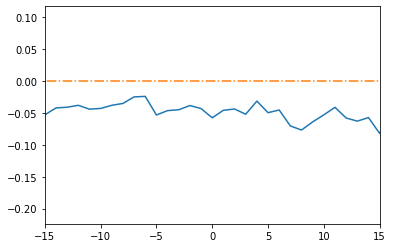

In [31]:
plt.plot(range(-21, 25), np.exp(results.params[2:48])-1)
plt.plot(range(-21, 25), [0 for _ in range(-21, 25)], linestyle='-.')
plt.xlim((-15,15))
